In [ ]:
#BiocManager::install("limma")

In [2]:
library(DESeq2)
library(limma)
library(ggplot2)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [3]:
counts <- read.csv(file.path("../data/", 'counts.csv'), header = TRUE, row.names = 1)
design <- read.csv(file.path("../data/", 'batches_meta_data.csv'), row.names = 1)
print(all(colnames(counts) %in% rownames(design)))
print(all(colnames(counts) == rownames(design)))

[1] TRUE
[1] TRUE


In [4]:
# create deseq2 object
dds <- DESeqDataSetFromMatrix(countData = counts, colData = design, design = ~ species)# + batch)
row.names(dds) <- row.names(counts)

# first do pre filtering to only keep rows with at least 10 assigned read pairs in atleast three samples
keep <- rowSums(counts(dds) >= 10) >= 3
summary(keep)
dds <- dds[keep,]

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


   Mode   FALSE    TRUE 
logical    5668   19499 

In [5]:
# differential expression analysis
dds <- DESeq(dds)
# results without lfc shrinkage
res <- results(dds,
               contrast = c("species","hypochondriacus","caudatus"),
               alpha = 0.01)

# lfc shrinkage using the apeglm method
res.shrunk <- lfcShrink(dds, 
                        res=res, 
                        coef = "species_hypochondriacus_vs_caudatus",
                        lfcThreshold = 1,
                        svalue = F,
                        type = "apeglm")
summary(res.shrunk, alpha=0.005)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 132 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

computing FSOS 'false sign or small' s-values (T=1)




out of 19499 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 614, 3.1%
LFC < -1.00 (down) : 833, 4.3%



In [6]:
res

log2 fold change (MLE): species hypochondriacus vs caudatus 
Wald test p-value: species hypochondriacus vs caudatus 
DataFrame with 19499 rows and 6 columns
           baseMean log2FoldChange     lfcSE      stat      pvalue        padj
          <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
AHq000001   423.562     -0.0711307  0.203341 -0.349809  0.72648187   0.8180653
AHq000002  1575.517      1.1707352  0.417818  2.802022  0.00507835   0.0225925
AHq000003   352.964      0.1625732  0.245036  0.663467  0.50703155   0.6456423
AHq000004   340.615      0.1500589  0.350279  0.428398  0.66836122   0.7742566
AHq000005   668.719      0.4259883  0.346253  1.230280  0.21859219   0.3580936
...             ...            ...       ...       ...         ...         ...
AHq024993   17.4648       0.591392  1.754516  0.337068          NA          NA
AHq024994   18.5756       2.115145  1.706238  1.239654          NA          NA
AHq025019  192.0462       0.356399  0.350347  1.01727

In [7]:
# use regularized-logarithm transformation
# blind=T to keep the experimental design from influencing the results 
rld <- rlog(dds, blind=T)

# Write to CSV
write.csv(assay(rld), "../data/rlog_transformed_data_without_batch.csv")

# remove batch effect
mat <- assay(rld)
mm <- model.matrix(~species, colData(rld))
mat <- limma::removeBatchEffect(mat, batch=rld$batch, design=mm)
assay(rld) <- mat

# Write to CSV
write.csv(assay(rld), "../data/rlog_transformed_data_wobatch_and_batch_effect.csv")
rld <- rlog(dds, blind=T)

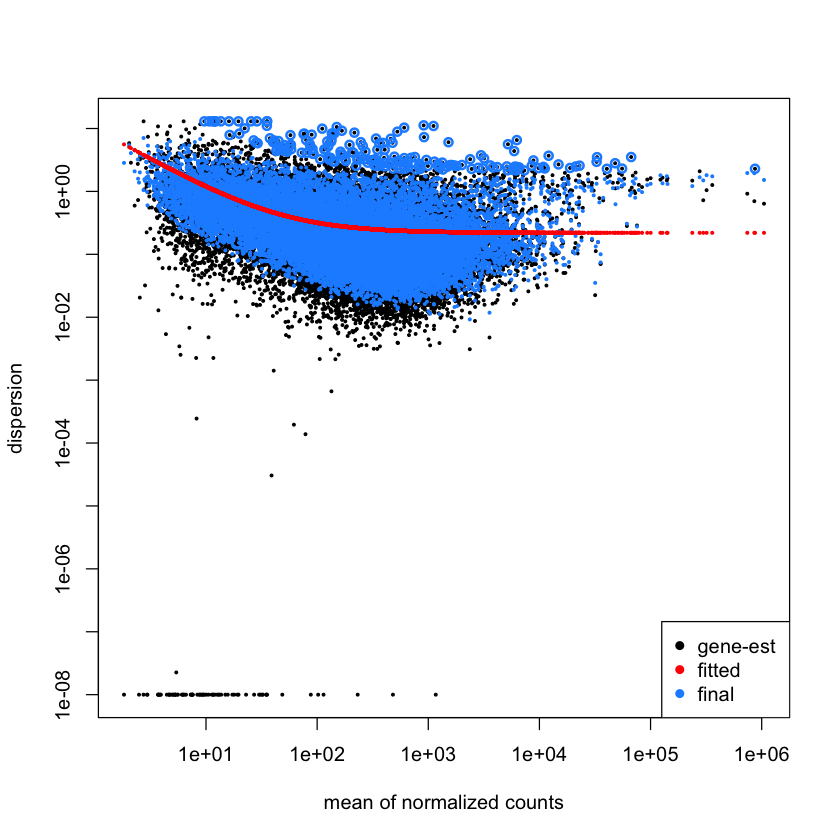

In [6]:
plotDispEsts(dds)

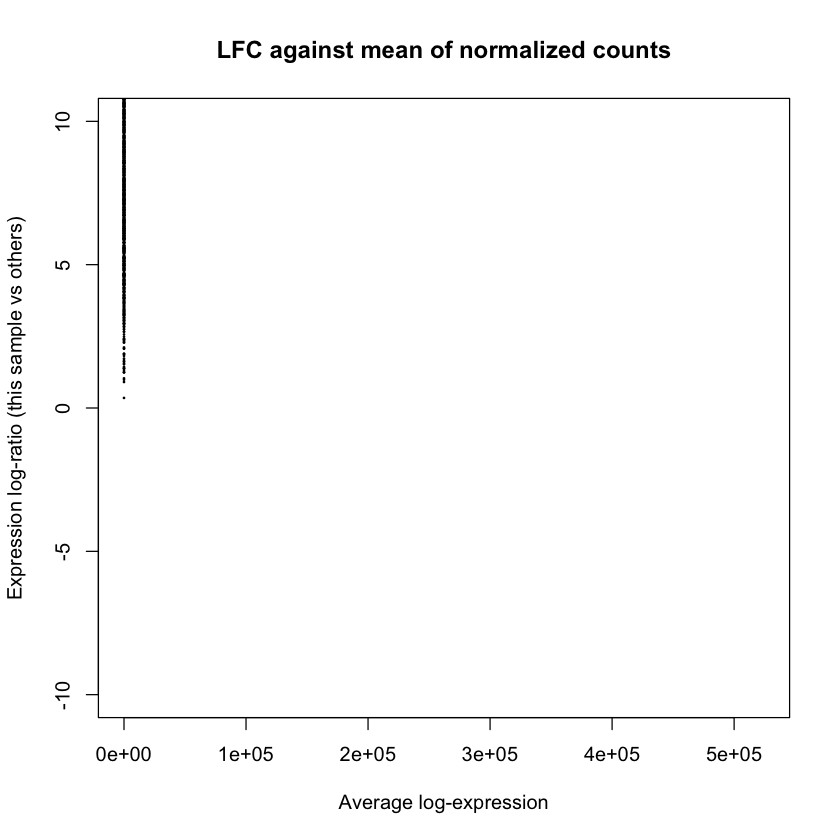

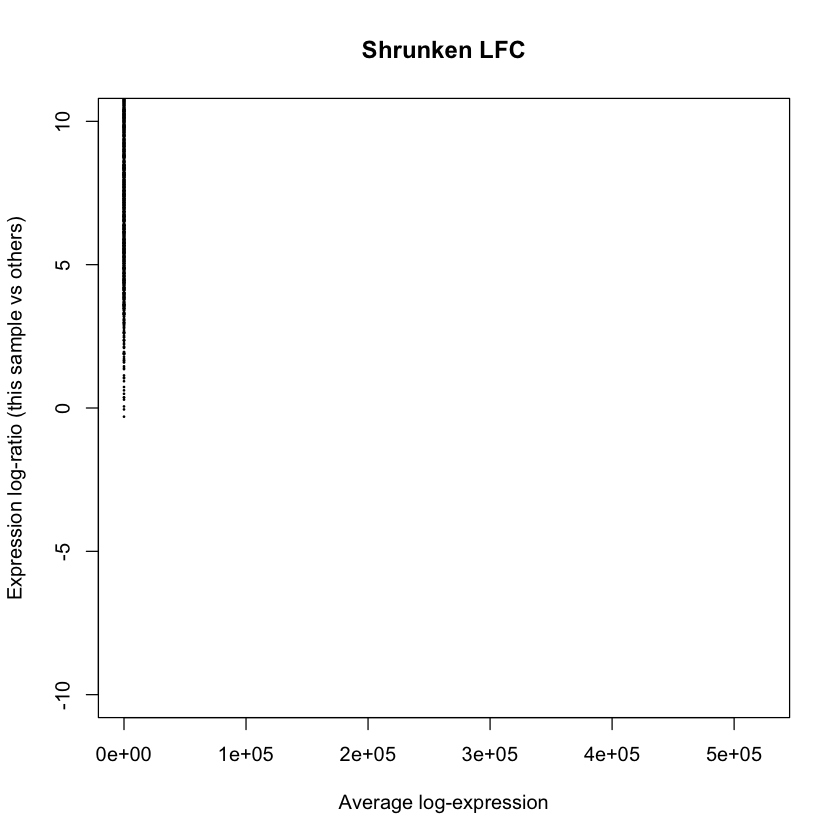

In [7]:
# plot LFC on mean of normalized counts, unshrunken values
plotMA(res, ylim=c(-10,10), main="LFC against mean of normalized counts")
# plot LFC on mean of normalized counts, shrunken values
plotMA(res.shrunk, ylim=c(-10,10), main="Shrunken LFC")

In [ ]:
```{r}
# create named vector of all expressed genes, indicating which genes are differentially expressed
sig <- res.shrunk[which(res.shrunk$svalue < 0.005 & abs(res.shrunk$log2FoldChange) > 1),]
all.genes <- as.integer(rownames(dds) %in% rownames(sig))
names(all.genes) <- rownames(res.shrunk)

# create named vector specifying the gene length
raw_lengths <- read.table("own path name")
raw_lengths <- raw_lengths[,1:2]
colnames(raw_lengths) <- c("transcript_id", "length")
raw_lengths <- raw_lengths %>%
  mutate(gene_id = gsub("\\..*", "", transcript_id))
raw_lengths <- raw_lengths %>%
  group_by(gene_id) %>%
  summarize(mean_length = median(length))
# construct vector, subset for expressed genes
gene.length <- raw_lengths$mean_length
names(gene.length) <- raw_lengths$gene_id
gene.length <- gene.length[names(gene.length) %in% rownames(res.shrunk)]

# create object with the mappings between gene names and GO-terms
annotation.raw <- read_table("data/functional_annotation/egg_nog_mapper_go_terms.txt", col_names = F, comment = "#")
#annotation.raw <- select(annotation.raw, V1, V0)
colnames(annotation.raw) <- c("transcript_id", "go_terms")
#annotation.raw <- annotation.raw[grep("GO", annotation.raw$go_terms),]
annotation.raw <- annotation.raw %>%
  mutate(gene_id = gsub("\\..*", "", transcript_id))

go_terms <- strsplit(annotation.raw$go_terms,"\\,")
names(go_terms) <- annotation.raw$gene_id
# concatenate all entries with the same name:
annotation.go <- split(unlist(go_terms, use.names = FALSE), rep(names(go_terms), lengths(go_terms)))

# remove all entries with unannotated go terms
annotation.go <- lapply(annotation.go, function(features, bad_features){
  return(features[!features %in% bad_features])
}, bad_features = "-")
annotation.go <- annotation.go[lapply(annotation.go, length)>0]
# remove all entries not in the expressed genes
#sig <- res.shrunk[which(res.shrunk$padj < 0.01 & abs(res.shrunk$log2FoldChange) > 1),]
annotation.go <- annotation.go[names(annotation.go) %in% rownames(res.shrunk)]
# remove any duplicated elements in the named list that were created by concatenating transcripts
annotation.go <- sapply(annotation.go, unique)
```